# Exorad 2.0

This Notebook will show you how to use exorad library to build your own pipeline. 

Before we start, let's silent the exorad logger.  

In [1]:
import warnings
warnings.filterwarnings("ignore")

from exorad.log import disableLogging

disableLogging()

## Preparing the instrument

### Load the instrument descrition
The first step is to load the instrument description. 
We use here the payload described in `examples/payload_example.xml`. 
We call the `LoadOptions` task that parses the xml file into a Python dictionary. 

In [2]:
from exorad.tasks import LoadOptions

payload_file = 'payload_example.xml'

loadOptions = LoadOptions()
payload = loadOptions(filename=payload_file)

## build the channels
Once we have the payload description we can build the channels using the `BuildChannels` taks, this will iterate over the channel and build each of the instruments listed in the payload config. To give it a closer look, let's do it step by step.

Inside `example_payload.xml` are described two channels: "Phot" that is a photometer and "Spec" that is a spectrometer. We want to build them and store them into a dictionary 

In [3]:
channels = {}

from exorad.tasks import BuildInstrument 
buildInstrument = BuildInstrument()

channels['Phot'] = buildInstrument(type="photometer", 
                                   name = "Phot", 
                                   description=payload['channel']['Phot'], 
                                   payload=payload, 
                                   write=False, output=None)
channels['Spec'] = buildInstrument(type="spectrometer", 
                                   name = "Spec", 
                                   description=payload['channel']['Spec'], 
                                   payload=payload, 
                                   write=False, output=None)

## Plot instrument photo-conversion efficiency

Thanks to exorad plotter you can easily plot the channels photon-conversion efficiency. To do so, we need to merge the channel output table to a cumulative table.

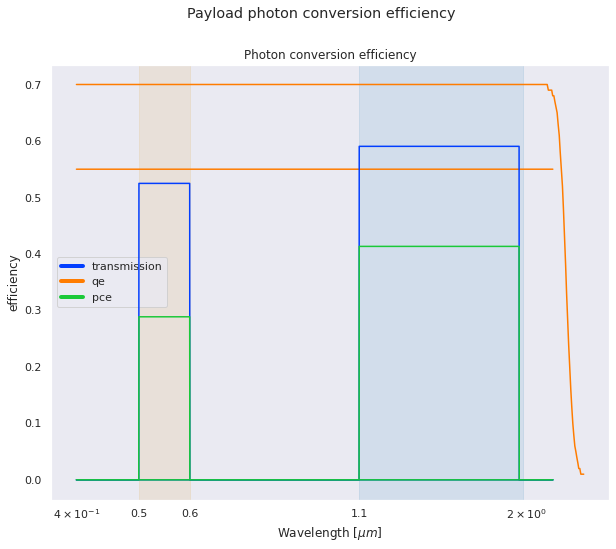

In [4]:
from exorad.tasks import MergeChannelsOutput

mergeChannelsOutput = MergeChannelsOutput()
table = mergeChannelsOutput(channels=channels)

from exorad.utils.plotter import Plotter

plotter = Plotter(channels=channels, input_table=table)
efficiency_fig = plotter.plot_efficiency()

## Acess the payload data

Assume you want to edit one of the payload parameters, for example you quant to move the Quatum Efficiency for the photometer from 0.55 to 0.65. 
Then you will need to build the channels again and produce an updated efficiency figure. 

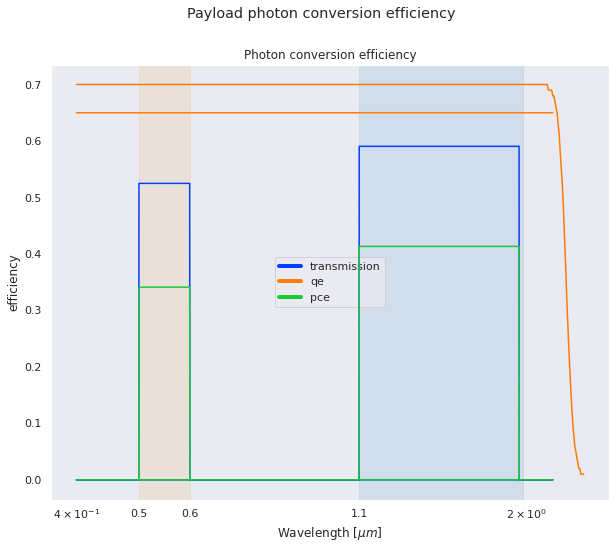

In [5]:
payload['channel']['Phot']['detector']['qe']['value'] = 0.65

from exorad.tasks import BuildChannels

buildChannels = BuildChannels()
channels = buildChannels(payload=payload, write=False, output=None)

table = mergeChannelsOutput(channels=channels)
plotter = Plotter(channels=channels, input_table=table)
efficiency_fig = plotter.plot_efficiency()

## Explore the telescope self emission

Even withot a target, we still have signal in our telescope coming from self emission. This can be expored with exorad. 
We can make a plot of the signals using the previous plotter. We have to manually set the lower limit for y-axes because exorad assumes 1e-3 ct/s as lower limit, but for the instrument we built the self emission is far lower because of the low temperature assumed (~60K for optics).

The self emission is stored in the channel output table in a column named `instrument_signal`. Information on the signal produced by each optical element can be retrieved in the channel dictionary under `['built_instr']['optical_path']['signal_table']`  

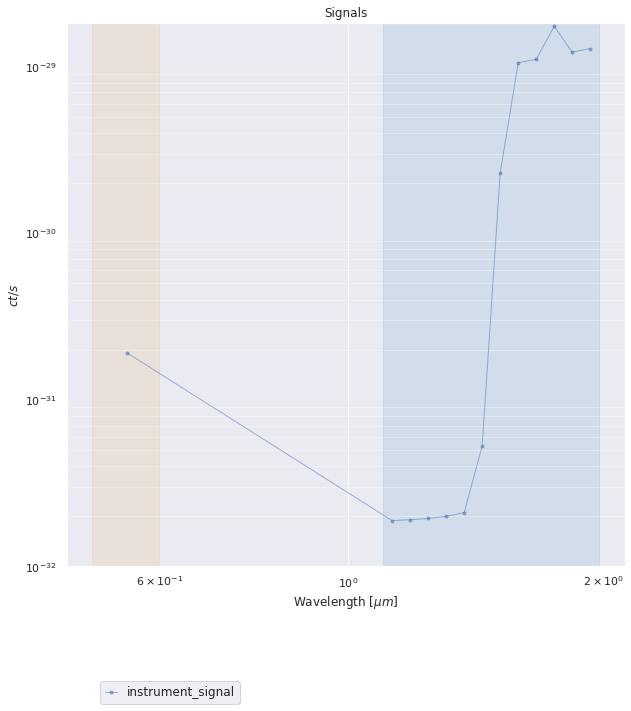

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = plotter.plot_signal(ax, ylim=1e-32, scale='log', channel_edges=False)

## Observing a target list

### Load a Target list

To observe a list of targets we first need to define them. Exorad can load target list from file, as the one you can find in `examples/test_target.csv`, or directly from Python. Because the first case is covered by the documentation, let's focus here on the latter. To describe a target in python, you need to use Astropy QTable and to follow the same notation used in the file and described in the documentation. Here we produce an example considering a single target called "test" that has mass 1 solar masses, effective temperature 5000 K, radius 1 solar radius and 10 pc away from us. Obviously, you can add more element to the list if you have more than one target. 

In [7]:
from astropy.table import QTable, Column
import astropy.units as u

names = Column(['test'], name='star name')
masses = Column([1]*u.M_sun, name='star M')
temperatures = Column([5000]*u.K, name='star Teff')
radii = Column([1] * u.R_sun, name='star R')
distances = Column([10] * u.pc, name='star D')
magK = Column([0]* u.Unit(""), name='star magK')
raw_targetlist = QTable([names, masses,temperatures, radii, distances, magK])

from exorad.tasks import LoadTargetList

loadTargetList = LoadTargetList()
targets = loadTargetList(target_list=raw_targetlist)

# "targets" is now a list of Target classes. 
# To read the content of the loaded element we need to convert the Target class into a dictionary
print(targets.target[0].to_dict())

{'star': {'M': {'value': 1.0, 'unit': 'solMass'}, 'Teff': {'value': 5000.0, 'unit': 'K'}, 'R': {'value': 1.0, 'unit': 'solRad'}, 'D': {'value': 10.0, 'unit': 'pc'}, 'magK': {'value': 0.0, 'unit': ''}}, 'id': 0}


### Foregrounds
Before you can observe a target you first need to prepare the table to fill. For that you need to call `PrepareTarget`. This populates the target attribute `table` that contains the merged channel tables and will be populated with the successive steps.  

Then we can think about the foregrounds. These are defined in the payload configuration file. In out case we have indicated a zodiacal foreground and a custom one described by a csv file. These are listed now in `payload['common']['foreground']`. The Task `EstimateForegrounds` builds both of them in one shot, but for the sake of learning, let's produce them one per time with their specific classes. The task mentioned requires the target as input and returns it as output because adds foreground information to the class.

Remember that the order is important when you list your contributions in your payload configuration file, because foregrounds can have both emission and transmission. In this optic, an element locate before another, has its light passed through the second one and so its total signal contribution is reduced. 

Text(0.5, 0.98, 'skyFilter')

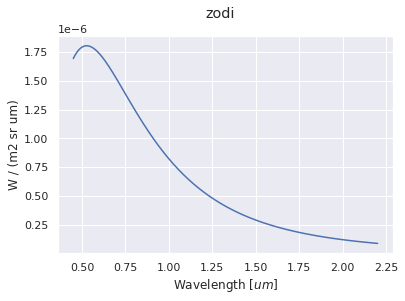

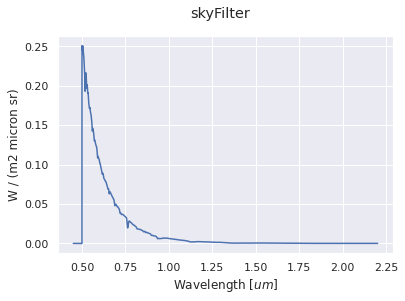

In [8]:
from exorad.tasks import PrepareTarget, EstimateForeground, EstimateZodi

target = targets.target[0]
wl_min, wl_max = payload['common']['wl_min']['value'], payload['common']['wl_max']['value']

prepareTarget = PrepareTarget()
target = prepareTarget(target=target, channels=channels)

estimateZodi = EstimateZodi()
target = estimateZodi(zodi=payload['common']['foreground']['zodiacal'],
                      target=target,
                      wl_range=(wl_min, wl_max))

estimateForeground = EstimateForeground()
target = estimateForeground(foreground=payload['common']['foreground']['skyFilter'],
                            target=target,
                            wl_range=(wl_min, wl_max))

# We plot now the foreground radiances
fig_zodi, ax = target.foreground['zodi'].plot()
fig_zodi.suptitle('zodi')
fig_sky, ax = target.foreground['skyFilter'].plot()
fig_sky.suptitle('skyFilter')

Once the contributions has been estimated, we can propagate them. Here we propagate and plot the foregrounds signal. The `PropagateForegroundLight` task also populates the target table with the computed foreground signal.

['chName', 'Wavelength', 'Bandwidth', 'LeftBinEdge', 'RightBinEdge', 'QE', 'WindowSize', 'TR', 'instrument_signal', 'instrument_MaxSignal_inPixel', 'skyFilter_signal', 'skyFilter_MaxSignal_inPixel', 'zodi_signal', 'zodi_MaxSignal_inPixel']


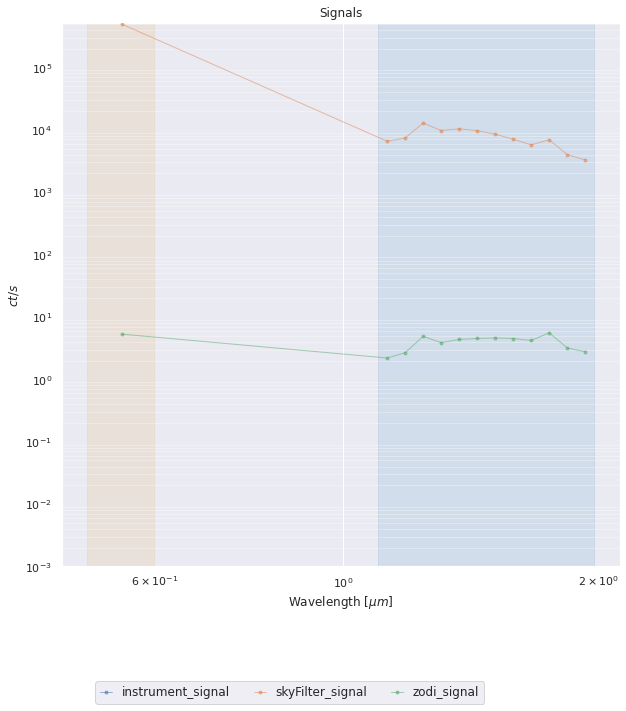

In [9]:
from exorad.tasks import PropagateForegroundLight

propagateForegroundLight = PropagateForegroundLight()
target = propagateForegroundLight(channels=channels, target=target)

plotter = Plotter(channels=channels, input_table=target.table)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = plotter.plot_signal(ax, scale='log', channel_edges=False)


# We show here the information content of the target table, that now contains also the foreground signal 
print(target.table.keys())

### Target source
We can now load the light source we are gonna use for the target. As described in the documentation, we can use a black body, or a phoenix star or a custom sed described in a csv file. Here we use a black body, as indicated in the payload configuration file `<sourceSpectrum> planck </sourceSpectrum>`, and now in the dic `payload['common']['sourceSpectrum']`.

Text(0.5, 0.98, 'test')

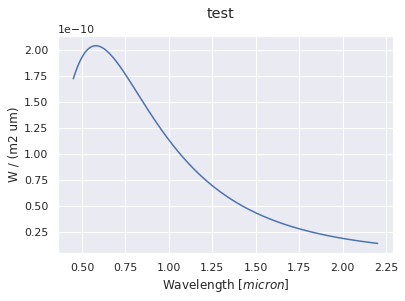

In [10]:
from exorad.tasks import LoadSource

loadSource = LoadSource()
target, sed = loadSource(target=target,
                         source=payload['common']['sourceSpectrum'],
                         wl_range=(wl_min, wl_max))

fig_source, ax=sed.plot()
fig_source.suptitle(target.name)

We can now propagate the source light. The light signal information will be added also to the target table

['chName', 'Wavelength', 'Bandwidth', 'LeftBinEdge', 'RightBinEdge', 'QE', 'WindowSize', 'TR', 'instrument_signal', 'instrument_MaxSignal_inPixel', 'skyFilter_signal', 'skyFilter_MaxSignal_inPixel', 'zodi_signal', 'zodi_MaxSignal_inPixel', 'foreground_transmission', 'starFlux', 'starSignal', 'star_signal_inAperture', 'star_MaxSignal_inPixel']


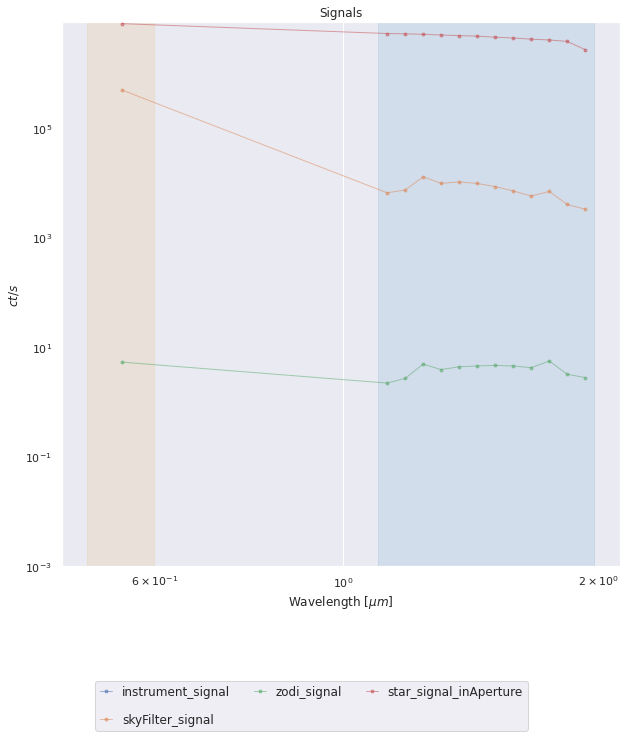

In [11]:
from exorad.tasks import PropagateTargetLight

propagateTargetLight = PropagateTargetLight()
target = propagateTargetLight(channels=channels, target=target)

plotter = Plotter(channels=channels, input_table=target.table)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = plotter.plot_signal(ax, scale='log', channel_edges=False)

# We show here the information content of the target table, that now contains also the source signal 
print(target.table.keys())

## Estimate the noise
The noise estimation is the last step. Exorad computes the photon noise from every signal considered so far, but aldo dark current noise and read noise from the detector. It also takes into account for custom noise source that can be added at channel level or at common level in the payload description. 

Finally, all these information will be adedd to the target table, that is now our final product.

['chName', 'Wavelength', 'Bandwidth', 'LeftBinEdge', 'RightBinEdge', 'QE', 'WindowSize', 'TR', 'instrument_signal', 'instrument_MaxSignal_inPixel', 'skyFilter_signal', 'skyFilter_MaxSignal_inPixel', 'zodi_signal', 'zodi_MaxSignal_inPixel', 'foreground_transmission', 'starFlux', 'starSignal', 'star_signal_inAperture', 'star_MaxSignal_inPixel', 'MaxSignal_inPixel', 'saturation_time', 'frameTime', 'instrument_signal_noise', 'skyFilter_signal_noise', 'zodi_signal_noise', 'star_signal_inAperture_noise', 'darkcurrent_noise', 'read_noise', 'total_noise', 'gain_noise', 'gain 2_noise', 'gain 3_noise']


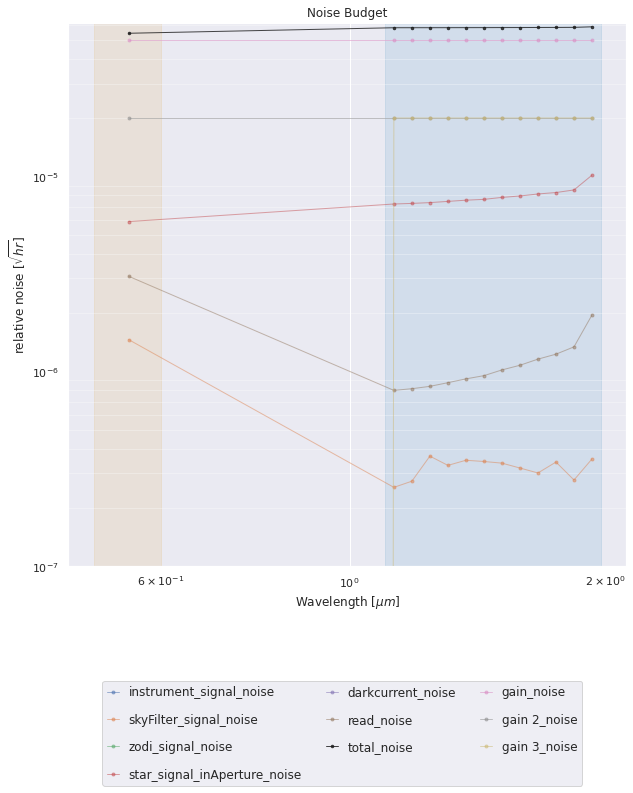

In [12]:
from exorad.tasks import EstimateNoise

estimateNoise = EstimateNoise()
target = estimateNoise(target=target, channels=channels)


plotter = Plotter(channels=channels, input_table=target.table)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = plotter.plot_noise(ax, scale='log', channel_edges=False)

# We show here the information content of the target table, that now contains also all the noise contributions 
print(target.table.keys())